In [1]:
from gurobipy import *
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

# Testing

In [2]:
output_file = 'variable_values'


In [3]:
results = pd.read_table(f'../output/{output_file}.txt')
n = results[results["results"].str.contains("n")]
u = results[results["results"].str.contains("u")]
c = results[results["results"].str.contains("c")]
varn = n['results'].str.split('=').apply(lambda x: x[0])
valn = n['results'].str.split('=').apply(lambda x: x[1])
t = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
k = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
amount = valn
specificn = pd.DataFrame(np.array([t,i,k,amount]).T).reset_index(drop=True)
specificn.columns = ['t','i', 'k', 'amount']
specificn['name'] = 'n'

varu = u['results'].str.split('=').apply(lambda x: x[0])
valu = u['results'].str.split('=').apply(lambda x: x[1])
t = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
j = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
k = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[3])
amount = valu
specificu = pd.DataFrame(np.array([t,i,j,k,amount]).T).reset_index(drop=True)
specificu.columns = ['t','i', 'j', 'k', 'amount']
specificu['name'] = 'u'

varc = c['results'].str.split('=').apply(lambda x: x[0])
valc = c['results'].str.split('=').apply(lambda x: x[1])
t = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
x = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
y = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[3])
amount = valc
specificc = pd.DataFrame(np.array([t,i,x,y,amount]).T).reset_index(drop=True)
specificc.columns = ['t','i', 'x', 'y', 'amount']
specificc['name'] = 'c'
specificn['amount'] = specificn['amount'].astype(float)
specificu['amount'] = specificu['amount'].astype(float)
specificc['amount'] = specificc['amount'].astype(float)


In [4]:
specificu

,t,i,j,k,amount,name
0,0,0,1,4,2.0,u
1,0,1,0,4,2.0,u
2,1,0,1,8,1.0,u
3,1,1,0,8,2.0,u
4,2,0,1,8,1.0,u
...,...,...,...,...,...,...
2750,1149,0,1,1,2.0,u
2751,1149,1,0,1,1.0,u
2752,1150,0,1,1,2.0,u
2753,1150,1,0,3,1.0,u


In [5]:
specificu01 = specificu[specificu['i'] == 0]
specificu10 = specificu[specificu['i'] == 1]

# specificu01 = specificu01.groupby('t').sum().reset_index()
# specificu10 = specificu10.groupby('t').sum().reset_index()


In [6]:
specificu01

,t,i,j,k,amount,name
0,0,0,1,4,2.0,u
2,1,0,1,8,1.0,u
4,2,0,1,8,1.0,u
6,3,0,1,6,1.0,u
7,3,0,1,8,1.0,u
...,...,...,...,...,...,...
2744,1146,0,1,4,1.0,u
2746,1147,0,1,1,1.0,u
2748,1148,0,1,2,2.0,u
2750,1149,0,1,1,2.0,u


In [7]:
gamma = [3.237872699, 3.729470167, 4.404786588, 5.379957014, 6.913363091,
        9.685271742, 16.30528373, 71.41103553]
gamma = np.array(gamma) / 5
gamma = np.ceil(gamma)

In [8]:
gamma

array([ 1.,  1.,  1.,  2.,  2.,  2.,  4., 15.])

In [9]:
start = 144
end = 288+144

In [10]:
def extract_day(df, start, end):
    return df.iloc[start:end].reset_index(drop=True)

def extract_day_from_t(df, start, end):
    return df[(df['t'] >= start) & (df['t'] <= end)].reset_index(drop=True)

def rename_columns(df):
    df.columns = ['t', 'num_flights', 'departure_time_sec']
    return df

def convert_timestep_to_sec(df, timestep=5):
    df['departure_time_sec'] = (df.loc[:, 't'] - start) * timestep * 60
    return df

def replicate_rows(df, column_name):
    return df.loc[df.index.repeat(df[column_name])].reset_index(drop=True)

def reorganize_df(df, start, end, timestep=5):
    df = extract_day_from_t(df, start, end)
    df = convert_timestep_to_sec(df, timestep)
    df = replicate_rows(df, 'amount')
    # df = rename_columns(df)
    return df

In [11]:
def get_charge_time(row):
    start = max(row['x']-1, 0)
    end = row['y']
    return sum(gamma[start:end])*60*5


In [12]:
extract_day_from_t(specificc, start, end)

,t,i,x,y,amount,name
0,144,0,0,1,1.0,c
1,144,0,1,4,1.0,c
2,144,0,3,4,1.0,c
3,144,1,0,1,1.0,c
4,145,0,1,4,1.0,c
...,...,...,...,...,...,...
798,431,1,0,3,3.0,c
799,432,0,0,1,1.0,c
800,432,0,1,4,1.0,c
801,432,0,3,4,1.0,c


In [13]:
soc_level = {
    0: 20,
    1: 30,
    2: 40,
    3: 50,
    4: 60,
    5: 70,
    6: 80,
    7: 90,
    8: 100
}

In [14]:
df_c = extract_day_from_t(specificc, start, end)
df_c['charging_start_time'] = (df_c['t']-start) * 5 * 60
df_c['charging_time'] = df_c.apply(get_charge_time, axis=1)
df_c['i'] = df_c['i'].apply(lambda x: 'LAX' if x == 0 else 'DTLA')
df_c.rename(columns={'amount': 'num_aircraft', 
                     'x': 'soc_start_level',
                     'y': 'soc_end_level',
                     'i': 'vertiport_id'}, inplace=True)
df_c['soc_start_level'] = df_c['soc_start_level'].apply(lambda x: soc_level[x])
df_c['soc_end_level'] = df_c['soc_end_level'].apply(lambda x: soc_level[x])
# Duplicate rows based on num_aircraft column
# df_c = df_c.loc[df_c.index.repeat(df_c.num_aircraft)].reset_index(drop=True)
df_c.drop(['t','name', 'num_aircraft'], axis=1, inplace=True)
df_c

,vertiport_id,soc_start_level,soc_end_level,charging_start_time,charging_time
0,LAX,20,30,0,300.0
1,LAX,30,60,0,1500.0
2,LAX,50,60,0,900.0
3,DTLA,20,30,0,300.0
4,LAX,30,60,300,1500.0
...,...,...,...,...,...
798,DTLA,20,50,86100,900.0
799,LAX,20,30,86400,300.0
800,LAX,30,60,86400,1500.0
801,LAX,50,60,86400,900.0


In [15]:
specificu01 = replicate_rows(specificu01, 'amount')
specificu10 = replicate_rows(specificu10, 'amount')

In [16]:
def create_flight_schedule(df, start, end, origin, destination):
    df = reorganize_df(df, start, end)
    # df = df.loc[df.index.repeat(df.num_flights)].reset_index(drop=True)
    df['origin'] = origin
    df['destination'] = destination
    df['departure_time_sec'] = df['departure_time_sec'] + df.groupby('departure_time_sec').cumcount() * 30
    df.drop(['t', 'i', 'j', 'name', 'amount'], axis=1, inplace=True)
    df.rename(columns={'k': 'soc'}, inplace=True)
    df['soc'] = df['soc'].apply(lambda x: soc_level[x])
    return df

In [17]:
lax_dtla = create_flight_schedule(specificu01, start, end, origin='LAX', destination='DTLA')
dtla_lax = create_flight_schedule(specificu10, start, end, origin='DTLA', destination='LAX')

In [18]:
flight_schedule = pd.concat([lax_dtla, dtla_lax]).sort_values('departure_time_sec').reset_index(drop=True)
flight_schedule

,soc,departure_time_sec,origin,destination
0,70,0,LAX,DTLA
1,40,0,DTLA,LAX
2,40,300,DTLA,LAX
3,50,300,LAX,DTLA
4,50,330,LAX,DTLA
...,...,...,...,...
1871,70,86400,LAX,DTLA
1872,40,86400,DTLA,LAX
1873,80,86430,DTLA,LAX
1874,80,86460,DTLA,LAX


In [19]:
def get_idling_aircraft(df, start, end):
    df = reorganize_df(df, start, end)
    # df = df.loc[df.index.repeat(df.num_flights)].reset_index(drop=True)
    df['origin'] = df['i'].apply(lambda x: 'LAX' if x == 0 else 'DTLA')
    df.drop(['t', 'i', 'name', 'amount'], axis=1, inplace=True)
    df.rename(columns={'k': 'soc'}, inplace=True)
    df['soc'] = df['soc'].apply(lambda x: soc_level[x])
    return df

In [20]:
get_idling_aircraft(specificn, start, end)

,soc,departure_time_sec,origin
0,20,0,DTLA
1,40,0,DTLA
2,30,300,LAX
3,30,300,LAX
4,50,300,LAX
...,...,...,...
228,20,85800,DTLA
229,20,85800,DTLA
230,20,86100,LAX
231,20,86400,DTLA


In [21]:
gamma = [3.237872699, 3.729470167, 4.404786588, 5.379957014, 6.913363091,
        9.685271742, 16.30528373, 71.41103553]
gamma = np.array(gamma) / 5
gamma = np.ceil(gamma)

In [22]:
specificc['t'].max()

1147

In [23]:
end = 1151

In [24]:
all_c = np.zeros(shape=(1,end), dtype=int)
for i in range(specificc.shape[0]):
    val = int(specificc['amount'][i])
    soc0 = int(specificc['x'][i])
    soc1 = int(specificc['y'][i])
    t = int(specificc['t'][i])
    time_charge = int(gamma[soc0: soc1].sum())
    occupied = np.zeros(shape=(val,end))
    for j in range(val):
        occupied[j][t:t+time_charge] = 1

    all_c = np.concatenate([all_c, occupied], axis=0)
all_c = all_c[1:,:]

all_u = np.zeros(shape=(1,end), dtype=int)
for i in range(specificu.shape[0]):
    val = int(specificu['amount'][i])
    t = int(specificu['t'][i])
    flight_time = 2
    flight = np.zeros(shape=(val,end))
    for j in range(val):
        flight[j][t:t+flight_time] = 1

    all_u = np.concatenate([all_u, flight], axis=0)
all_u = all_u[1:,:]

In [25]:

all_n = np.zeros(shape=(1,end+2), dtype=int)
for i in range(specificn.shape[0]):
    val = int(specificn['amount'][i])
    t = int(specificn['t'][i])
    idle = np.zeros(shape=(val,end+2))
    for j in range(val):
        idle[j][t] = 1
    all_n = np.concatenate([all_n, idle], axis=0)
all_n = all_n[1:,:-1]

## Total Number of Aircraft Checking

<Axes: >

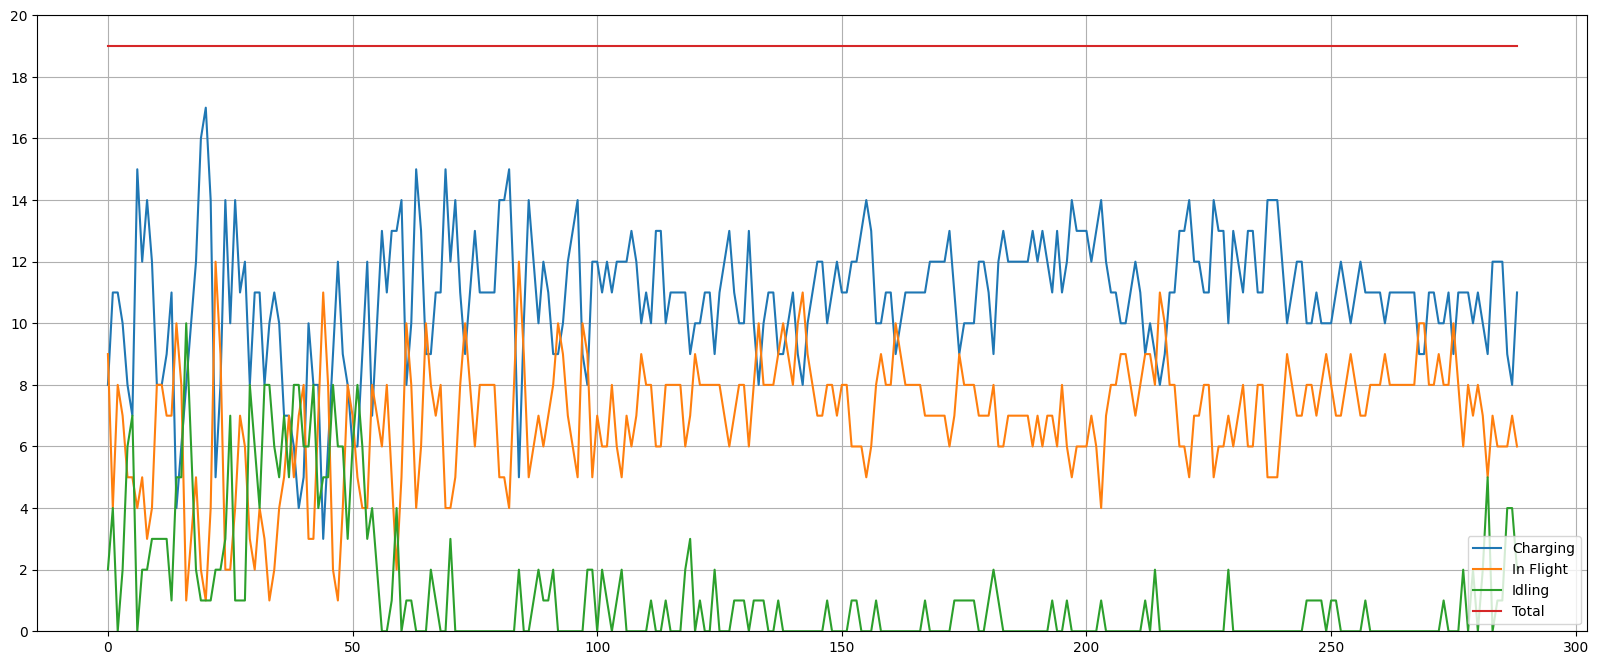

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
x0 = 144+288
x1 = 144+288*2+1

fig, ax = plt.subplots(figsize=(20,8))
ax.set_ylim([0, 20])
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True)) # sets y-axis ticks at integer values

ax.grid(True) # enable grid

sns.lineplot(all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1]+all_n.sum(axis=0)[x0:x1]), label='Total', ax=ax)


In [36]:
display(all_c.sum(axis=0)[144])
display(all_u.sum(axis=0)[144])
display(all_n.sum(axis=0)[144])

12.0

5.0

2.0

In [37]:
display(all_c.sum(axis=0)[144+288])
display(all_u.sum(axis=0)[144+288])
display(all_n.sum(axis=0)[144+288])

8.0

9.0

2.0

In [38]:
specificu01 = specificu[specificu['i'] == 0]
specificu10 = specificu[specificu['i'] == 1]

In [39]:
specificu01 = specificu01.groupby('t').sum().reset_index()
specificu10 = specificu10.groupby('t').sum().reset_index()


# N-T Diagram

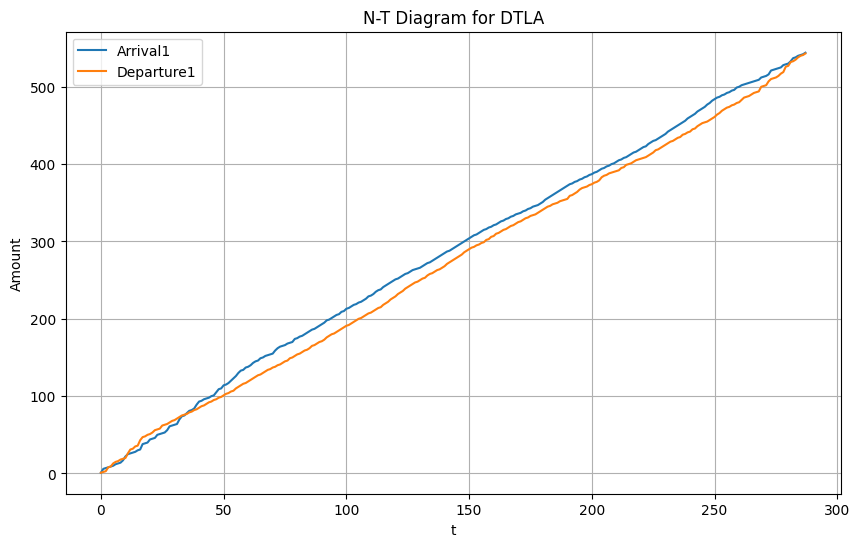

In [40]:
# Data from specificu
specificu_t01 = list(specificu01['t']+2)
specificu_amount01 = list(specificu01['amount'])
specificu_t10 = list(specificu10['t'])
specificu_amount10 = list(specificu10['amount'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(specificu_amount01[144:144+288]), label='Arrival1')
plt.plot(np.cumsum(specificu_amount10[144:144+288]), label='Departure1')
plt.xlabel('t')
plt.ylabel('Amount')
plt.title('N-T Diagram for DTLA')
plt.legend()
plt.grid()
plt.show()


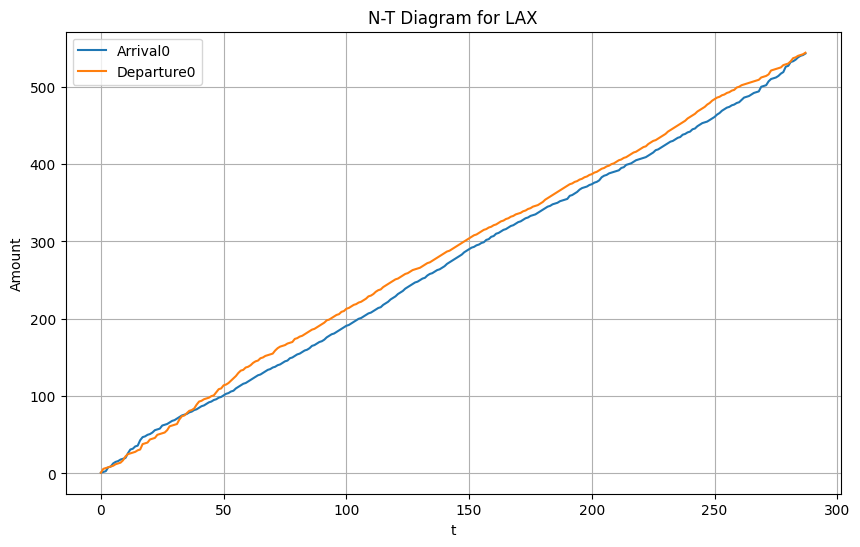

In [41]:
# Data from specificu
specificu_t01 = list(specificu01['t'])
specificu_amount01 = list(specificu01['amount'])
specificu_t10 = list(specificu10['t']+2)
specificu_amount10 = list(specificu10['amount'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(specificu_amount10[144:144+288]), label='Arrival0')
plt.plot(np.cumsum(specificu_amount01[144:144+288]), label='Departure0')

plt.xlabel('t')
plt.ylabel('Amount')
plt.title('N-T Diagram for LAX')
plt.legend()
plt.grid()
plt.show()


## Ground Features

In [42]:
def calculate_num_aircrafts(specificc, specificu, specificn):
    end = specificc['t'].max()
    all_c = np.zeros(shape=(1,end), dtype=int)
    for i in range(specificc.shape[0]):
        val = int(specificc['amount'][i])
        soc0 = int(specificc['x'][i])
        soc1 = int(specificc['y'][i])
        t = int(specificc['t'][i])
        time_charge = int(gamma[soc0: soc1].sum())
        occupied = np.zeros(shape=(val,end))
        for j in range(val):
            occupied[j][t:t+time_charge] = 1

        all_c = np.concatenate([all_c, occupied], axis=0)
    all_c = all_c[1:,:]

    all_u = np.zeros(shape=(1,end), dtype=int)
    for i in range(specificu.shape[0]):
        val = int(specificu['amount'][i])
        t = int(specificu['t'][i])
        flight_time = 2
        flight = np.zeros(shape=(val,end))
        for j in range(val):
            flight[j][t:t+flight_time] = 1

        all_u = np.concatenate([all_u, flight], axis=0)
    all_u = all_u[1:,:]


    all_n = np.zeros(shape=(1,end+2), dtype=int)
    for i in range(specificn.shape[0]):
        val = int(specificn['amount'][i])
        t = int(specificn['t'][i])
        idle = np.zeros(shape=(val,end+2))
        for j in range(val):
            idle[j][t] = 1
        all_n = np.concatenate([all_n, idle], axis=0)
    all_n = all_n[1:,:-1]

    return all_c, all_n, all_u

In [43]:
specificu01 = specificu[specificu['i'] == 0].reset_index(drop=True)
specificu10 = specificu[specificu['i'] == 1].reset_index(drop=True)

specificc01 = specificc[specificc['i'] == 0].reset_index(drop=True)
specificc10 = specificc[specificc['i'] == 1].reset_index(drop=True)

specificn01 = specificn[specificn['i'] == 0].reset_index(drop=True)
specificn10 = specificn[specificn['i'] == 1].reset_index(drop=True)


In [44]:
lax_all_c, lax_all_n, lax_all_u = calculate_num_aircrafts(specificc01, specificn01, specificu01)

IndexError: index 1145 is out of bounds for axis 0 with size 1145

In [ ]:
dtla_all_c, dtla_all_n, dtla_all_u = calculate_num_aircrafts(specificc10, specificn10, specificu10)

[Text(0.5, 1.0, 'State of Aircrafts at LAX')]

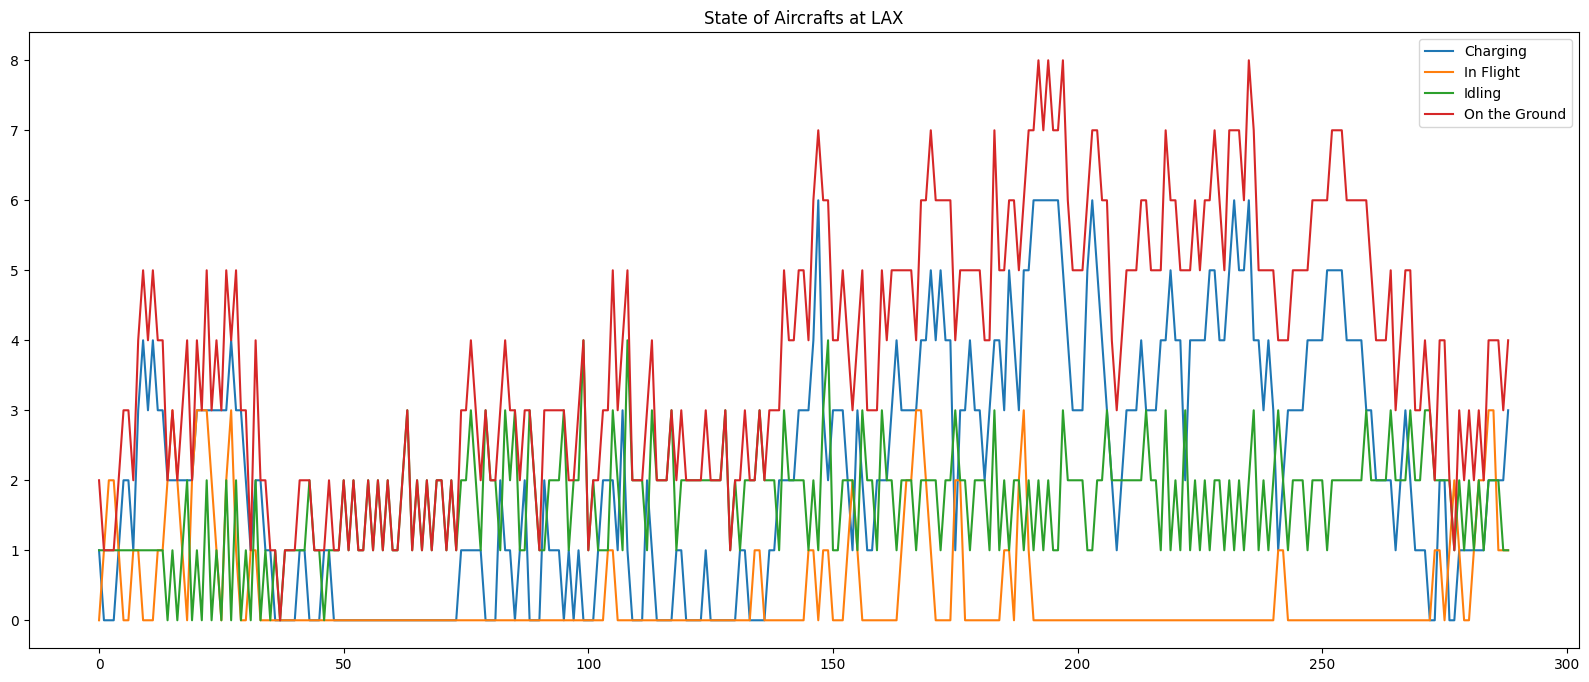

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
x0 = 144+288
x1 = 144+288*2+1

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(lax_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(lax_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(lax_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((lax_all_c.sum(axis=0)[x0:x1] + lax_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax)
ax.set(title='State of Aircrafts at LAX')

[Text(0.5, 1.0, 'State of Aircrafts at DTLA')]

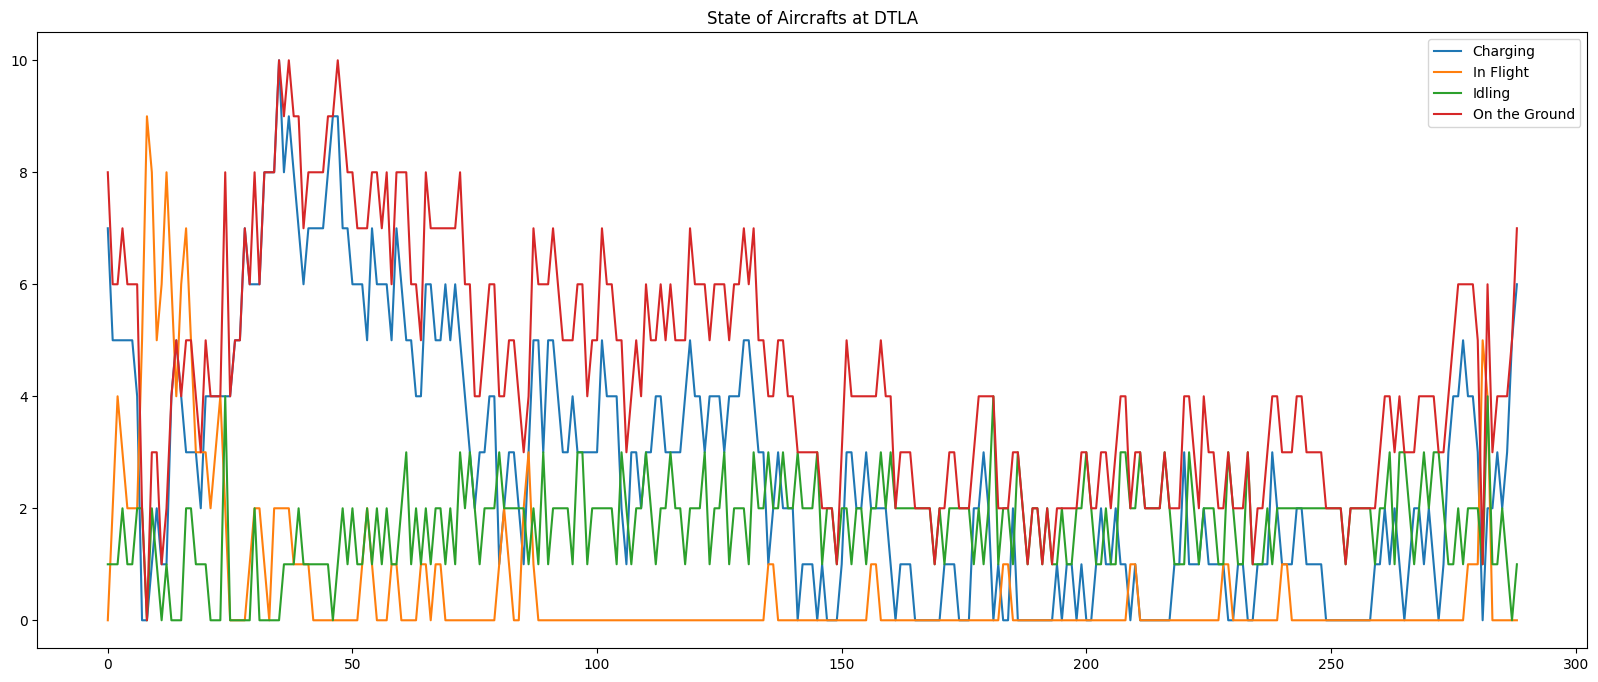

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
x0 = 144+288
x1 = 144+288*2+1

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(dtla_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(dtla_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(dtla_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((dtla_all_c.sum(axis=0)[x0:x1] + dtla_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax)
ax.set(title='State of Aircrafts at DTLA')